# Assignment 2: Development of garbage classification model 
# Group 3: Chibuike Peter Ohanu and Irtaza Sohail

# Importing all the  necessary libraries

In [ ]:
# Import necessary libraries
import torch
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import time

# Checking the available device for the training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Setting the path to dataset folders

In [ ]:
# Paths for train, validation, and test datasets
TRAIN_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Train"
VAL_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Val"
TEST_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Test"

# Defining class names
class_names = ["Red", "Blue", "Black", "TTR"]


# Dataset exploration functions

In [ ]:
# Dataset exploration and print image size and formats
# To decide on how to preprocess the data
def explore_dataset(dataset_path):
    sizes = []
    formats = set()
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            with Image.open(image_path) as img:
                sizes.append(img.size)
                formats.add(img.format)
    print("Image Sizes:", sizes[:5], "...")
    print("Image Formats:", formats)




# Pre-process the data

In [ ]:
# Step 2: Pre-process the data 
# Define a custom function to pad images to a square shape
# To ensure that all the images are of equal size and can be trained by the model
def pad_to_square(image):
    width, height = image.size
    max_dim = max(width, height)
    padding = (
        (max_dim - width) // 2,
        (max_dim - height) // 2,
        (max_dim - width) - (max_dim - width) // 2,
        (max_dim - height) - (max_dim - height) // 2
    )
    return transforms.functional.pad(image, padding, fill=0, padding_mode="constant") # To add black border around all images

# Transformations for pre-processing and data augmentation
image_transform = transforms.Compose([
    transforms.Lambda(pad_to_square),      # Pad image to square shape
    transforms.Resize((224, 224)),         # Resize all images to 224x224 after padding. Since the images are square, resizing maintains the aspect ratio
    transforms.RandomHorizontalFlip(),     #Transforming data for data augmentation
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing the images with the mean and standard deviation of the dataset on which the original model was trained 
])  


# Experimental Setup

In [ ]:
# Step 3: Experimental setup 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Loads a pre-trained DistilBERT tokenizer for text feature extraction
max_len = 128 # Sets the maximum length for text tokenization

# Dataset Class
class CustomImageTextDataset(Dataset):  # Defines a custom dataset class inheriting from PyTorch’s Dataset, which allows loading and processing paired image and text data.
    def __init__(self, image_dir, tokenizer, max_len, image_transform=None):  
        self.image_paths, self.texts, self.labels = [], [], []  
        self.tokenizer = tokenizer  
        self.max_len = max_len  
        self.image_transform = image_transform  # Image transformations to be applied to each image.

        class_folders = sorted(os.listdir(image_dir))  .
        label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}  # To get class name from folder name  
        self.label_map = label_map  

        for class_name in class_folders:  # Sorting all the images from the directory 
            class_path = os.path.join(image_dir, class_name)  
            if os.path.isdir(class_path):  
                for file_name in os.listdir(class_path):  
                    if file_name.endswith(('.png', '.jpg')):  
                        self.image_paths.append(os.path.join(class_path, file_name))  
                        self.texts.append(os.path.splitext(file_name)[0].replace('_', ' '))  # Removing spaces to rename images 
                        self.labels.append(label_map[class_name])  

    def __len__(self): 
        return len(self.image_paths)   # Returns the total number of images

# Loads and preprocesses an image and its associated text data, returning them in a format suitable for model input
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB") # Coverts the images to RGB format if they are in a different format
        if self.image_transform:
            image = self.image_transform(image)

        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt' # Returns the output as PyTorch tensors
        )

        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets and loaders
train_dataset = CustomImageTextDataset(image_dir=TRAIN_PATH, tokenizer=tokenizer, max_len=max_len, image_transform=image_transform)
val_dataset = CustomImageTextDataset(image_dir=VAL_PATH, tokenizer=tokenizer, max_len=max_len, image_transform=image_transform)
test_dataset = CustomImageTextDataset(image_dir=TEST_PATH, tokenizer=tokenizer, max_len=max_len, image_transform=image_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Apply Transfer learning 

In [ ]:
# Step 4: Transfer learning 
class GarbageModel(nn.Module):
    def __init__(self, num_classes, input_shape=(3, 224, 224), transfer=True):
        super(GarbageModel, self).__init__()

        # Text feature extraction
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased') # Using pretrained model
        self.drop = nn.Dropout(0.3)
        self.text_out = nn.Linear(self.distilbert.config.hidden_size, 256)
        self.text_norm = nn.LayerNorm(256)

        # ResNet50 for image feature extraction
        self.feature_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if transfer else None) # Using pretrained model
        self.feature_extractor.fc = nn.Identity()   # Replace the final fully connected layer of ResNet with an identity layer to extract features directly
        if transfer:
            for param in self.feature_extractor.parameters(): # Freeze all layers of the feature extractor to retain pre-trained weights
                param.requires_grad = False
            for param in self.feature_extractor.layer4.parameters():  # Unfreeze only the last layer block to allow fine-tuning on higher-level features
                param.requires_grad = True

        n_image_features = self._get_conv_output(input_shape)     # Calculate the number of output features from the feature extractor
        self.image_classifier = nn.Linear(n_image_features, 256) # Using 256 features to give equal importance to image and text
        self.image_norm = nn.LayerNorm(256)  # Apply layer normalization for multi model and it gives better result than batch norm

        # Final classification layer
        self.classifiermain = nn.Linear(256 + 256, num_classes) 

    # This function extracts number of features 
    def _get_conv_output(self, shape): 
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape)) # This check the model's output dimensions.
        output_feat = self.feature_extractor(tmp_input)
        n_size = output_feat.data.view(batch_size, -1).size(1)  # Flatten the output features and calculate the size of the resulting vector.
        return n_size

    def forward(self, images, input_ids, attention_mask):
        text_features = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        text_features = self.drop(text_features)
        text_features = self.text_out(text_features)
        text_features = self.text_norm(text_features)

        image_features = self.feature_extractor(images)
        image_features = image_features.view(image_features.size(0), -1)
        image_features = self.image_classifier(image_features)
        image_features = self.image_norm(image_features)

        combined_features = torch.cat((text_features, image_features), dim=1)   # This Concatenate text and image features
        output = self.classifiermain(combined_features)  # The combined features is pass through the final classifier to produce the output for each class.
        return output

num_classes = len(train_dataset.label_map)
model = GarbageModel(num_classes=num_classes).to(device)


#  Loss and metrics calculation

In [ ]:
# Step 5: Loss and metrics 
class_weights = torch.tensor([2, 1, 2.1, 2.2], dtype=torch.float).to(device) #Assigning relative importance to the classes depending on number of samples
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
num_epochs = 10

# Set callbacks and tracking

In [ ]:
# Callback functions are embedded within the training loop
# Save the best model with early stopping
best_val_loss = float('inf')

# Train the model

In [ ]:
# Step 8: Train model
def train(model, train_loader, val_loader):
    global best_val_loss
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        scheduler.step(val_loss / len(val_loader))
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth") # Save the best model weights

        accuracy = accuracy_score(all_labels, all_preds)  # Calculate the accuracy for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

train(model, train_loader, val_loader)

# Test the model

In [ ]:
# Step 9: Test model
def evaluate(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds, average='macro')
    specificity = precision_score(all_labels, all_preds, average='macro')
    print(f"Test Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))
    return cm

# Evaluate and plot confusion matrix

In [ ]:
# Evaluate and plot confusion matrix
cm = evaluate(model, test_loader)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Define the path to save the confusion matrix
save_path = "/home/chibuike.ohanu/work/garbage_transfer_learning/confusion_matrix_tl_text.png"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the confusion matrix as an image file
plt.savefig(save_path)
plt.close()


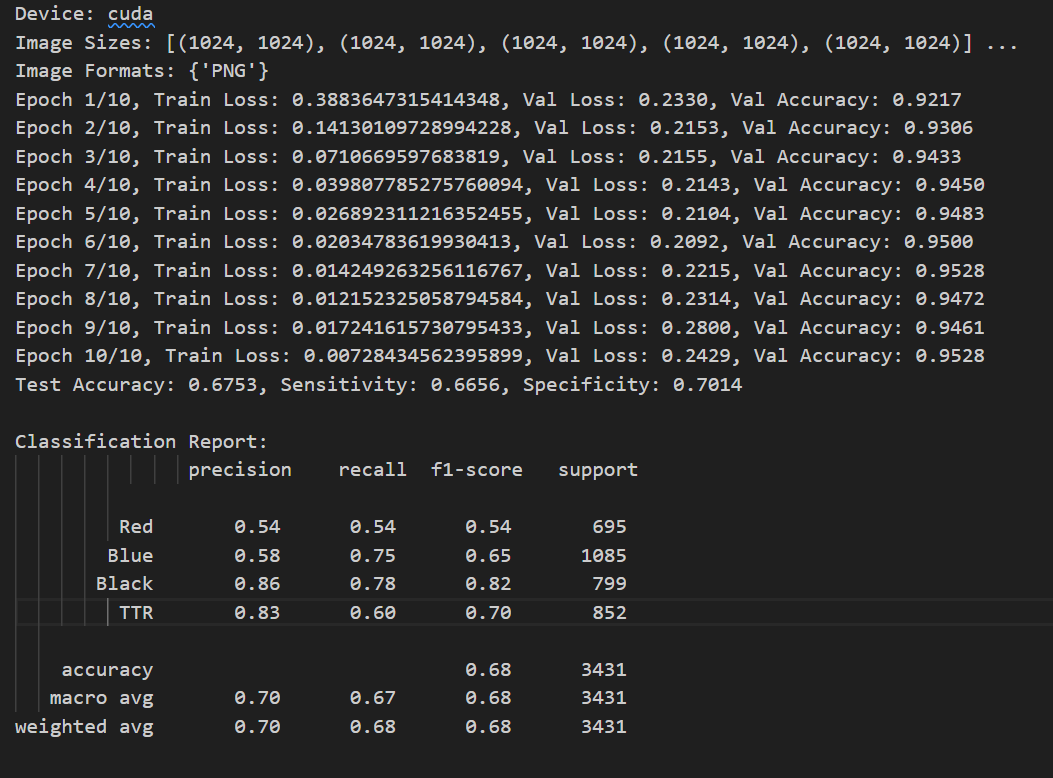

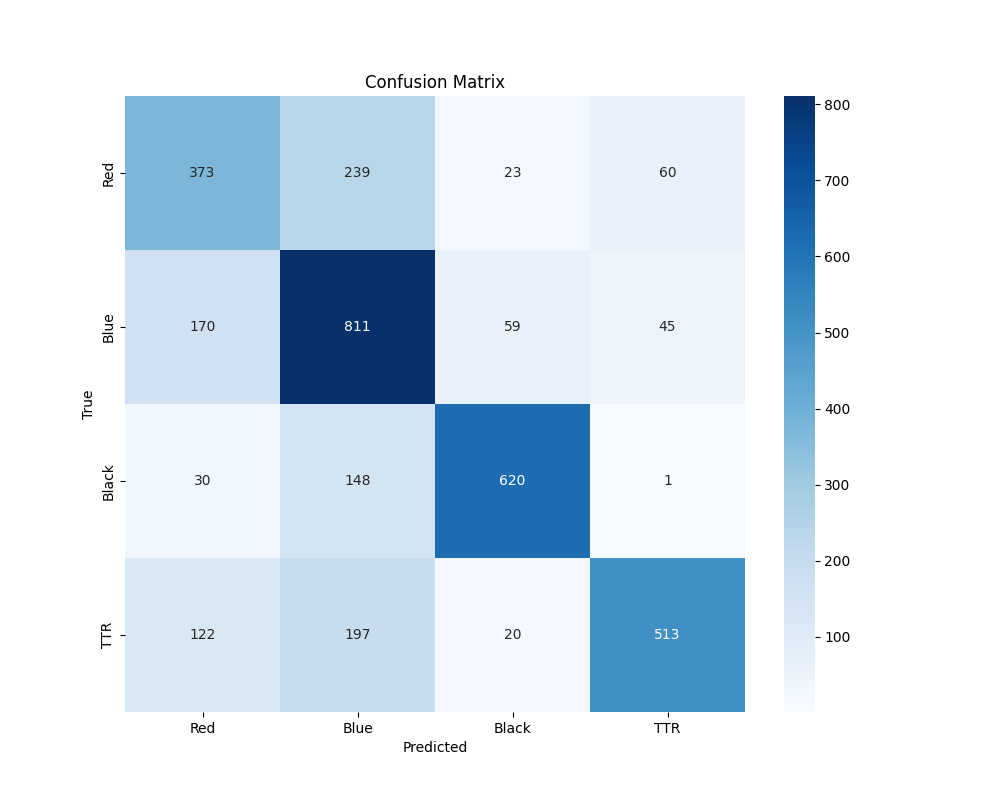